# A/B testing 
# & Bayesian multi-armed bandits 
# made simple for everyone.

##### Clement Riedel, July 2016


You have two doors: one blue, one green. You want to know which one people are going to open. 

<img src="AB_testing_TwoDoors.png">

This is a metaphor. A/B testing is about predicting people's behavior and it does not matter if you think that they are opening a door, clicking on a button, registering to a website, putting an item in a basket or liking something... To make our study more concrete, we will consider the following case:

*** You own a website and you want to know if users are more likely to "register" (click on a button to get in) if the website theme is blue or green. ***

Let's design a very simple experiment. You are going to split the next 1000 users in half: 500 are going to view the blue website (Website A) while the other 500 are going to see the green one (Website B). We record the number of views and registration for each website.

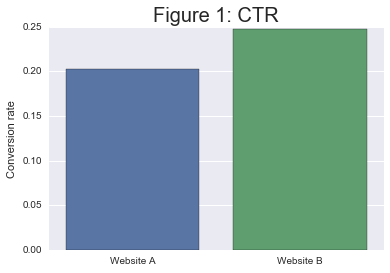

In [1]:
# Website A (Blue):
views_A = 503
regs_A = 102

# Website B (Green):
views_B = 501
regs_B = 124

# Total number of views and registrations on both sites
total = views_A + views_B + regs_A + regs_B

#not_conv: Number of users who have not converted from view to registration.
not_conv_A = views_A - regs_A 
not_conv_B = views_B - regs_B

#Plot of the conversion rate (percent of users that do register after viewing the site)
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt
x = ['Website A', 'Website B']
ax = sns.barplot(x, [regs_A/float(views_A), regs_B/float(views_B)])
ax.set_title('Figure 1: CTR', fontsize=20)
sns.axlabel('', 'Conversion rate')

Well that's great: Website B is performing better than Website A, let's move on. Are you sure? There is way more information that we can obtain, such as: **What is the probability that Website B performs better than Website A just by chance?** (If you were to repeat the same experiment how confident are you would that you would observe the same trend?). These questions can be anwsered using classical statistics (Z-test and Chi-square). 

If you think that some events can be described with some 'degrees of belief', and are interested to know about how to quantify them, you should read up to the Bayesian part. We are going to draw distributions, we are going to make it simple. My goal is to share with you the idea that Figure 2 is more beautiful and informative than Figure 1.

# Z-test

If you are not familiar with statistics, we advise you to look at the <a href="https://www.khanacademy.org/math/probability/statistics-inferential">Inferential statistics</a> class from Khan Academy. If you understand the three following points, you should be able to follow:
- We make the hypothesis that both websites are equivalent (i.e. they have the same conversion rate.) We call it the "Null hypothesis".
- The p-value is the probability to obtain the observed result (or something "more extrem") when the null hypothesis is true.
- The 'Two Samples z-test for Proportions' permits to find the z-value (see <a href="http://math.mercyhurst.edu/~griff/courses/m109/Lectures/sect8.4.pdf">this pdf</a> for more details) and using tables we can then compute the p-value.

An alternative to manually coding the z value and looking at the p-value in a table is to use the proportions_ztest from statsmodels:

In [2]:
import numpy as np
from statsmodels.stats.proportion import proportions_ztest

views = np.array([views_A, views_B])
regs = np.array([regs_A,regs_B])

z,p = proportions_ztest(regs, views, value=0)
print('z-stat = {:.2} \np-value = {:.2}'.format(z, p/2))

z-stat = -1.7 
p-value = 0.045


In [3]:
print('The probability to observe that site B performs better than site A while the ground truth is that they are equivalent is {:.2}.'.format(p/2))
print('')
print('If the p-value is small (usally p < 0.05) statisticians reject the null hypothesis that the sites are equivalent and conclude that B performs better.')

The probability to observe that site B performs better than site A while the ground truth is that they are equivalent is 0.045.

If the p-value is small (usally p < 0.05) statisticians reject the null hypothesis that the sites are equivalent and conclude that B performs better.


# Chi square

In this study's condition, the z-test and chi square test (a non parametric test) leads to the same p-value:

In [4]:
from scipy.stats import chi2_contingency
chi2, p, dof, expected = chi2_contingency([[regs_A, not_conv_A], [regs_B, not_conv_B]], correction=False)
print('p-value = {:.2}'.format(p/2))

p-value = 0.045


# Bayesian inference, Beta distribution

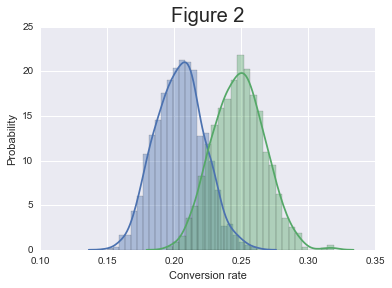

In [5]:
from numpy.random import beta as beta_dist

A_samples = beta_dist(regs_A+1, not_conv_A+1, total)
B_samples = beta_dist(regs_B+1, not_conv_B+1, total)

ax = sns.distplot(A_samples)
ax = sns.distplot(B_samples)
ax.set_title('Figure 2', fontsize=20)
sns.axlabel('Conversion rate', 'Probability')

In [6]:
np.mean(A_samples)

0.2040418751140671

In [7]:
proba = np.mean(B_samples > A_samples)
print('Probability = {}'.format(proba))

np.mean(100.*(B_samples - A_samples)/A_samples > 5)

Probability = 0.949593495935


0.89186991869918697

References: 

http://www.evanmiller.org/bayesian-ab-testing.html

http://engineering.richrelevance.com/bayesian-ab-tests/

http://dogdogfish.com/ab-testing/bayesian-ab-testing-using-python/

http://www.prenhall.com/behindthebook/0136149901/pdf/Levine_CH12.pdf

In [31]:
#Generate two arrays corresponding to the websites
A = np.array([0] * not_conv_A + [1] * regs_A)
np.random.shuffle(A)

B = np.array([0] * not_conv_B + [1] * regs_B)
np.random.shuffle(B)

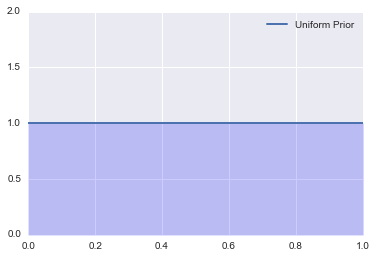

In [32]:
def plot_with_fill(x, y, label, color):
    lines = plt.plot(x, y, label=label, lw=2)
    plt.fill_between(x, 0, y, alpha=0.2, color=color)

import scipy.stats as stats
x = np.arange(0, 1.001, 0.001)
y = stats.uniform.pdf(x)
plot_with_fill(x, y, "Uniform Prior", 'b')
plt.ylim(0, 2)
plt.legend()
plt.show()

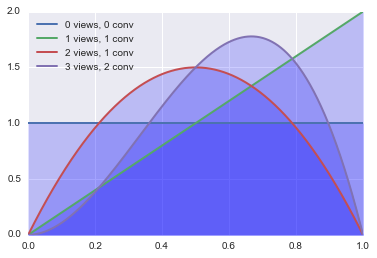

In [33]:
BetaEx1Alpha = [0,1,1,2,2]
BetaEx1Beta = [0,0,1,1,2]
for num in [0,1,2,3]:
    alpha = BetaEx1Alpha[num]+1
    beta = BetaEx1Beta[num]+1
    y = stats.beta.pdf(x, alpha, beta)
    plot_with_fill(x, y, label="{0} views, {1} conv".format(BetaEx1Alpha[num]+BetaEx1Beta[num], BetaEx1Alpha[num]), color='b')
    plt.legend(loc=2)

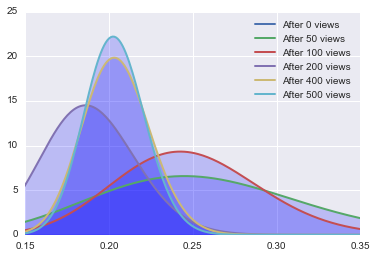

In [34]:
for num in [0, 50, 100, 200, 400, 500]:
    alpha = A[:num].sum() + 1
    beta = num - alpha + 1
    y = stats.beta.pdf(x, alpha, beta)
    plot_with_fill(x, y, label="After {0} views".format(num), color='b')
plt.xlim(0.15, 0.35)
plt.legend()
plt.show()

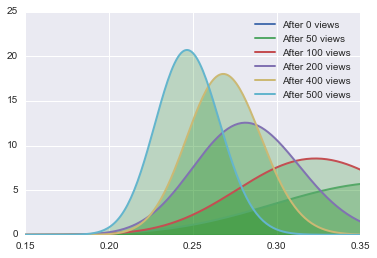

In [35]:
for num in [0, 50, 100, 200, 400, 500]:
    alpha = B[:num].sum() + 1
    beta = num - alpha + 1
    y = stats.beta.pdf(x, alpha, beta)
    plot_with_fill(x, y, label="After {0} views".format(num), color='g')
plt.xlim(0.15, 0.35)
plt.legend()
plt.show()

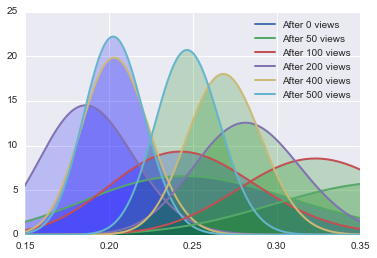

In [36]:
for num in [0, 50, 100, 200, 400, 500]:
    alphaA = A[:num].sum() + 1
    betaA = num - alphaA + 1
    ya = stats.beta.pdf(x, alphaA, betaA)
    plot_with_fill(x, ya, label="After {0} views".format(num), color='b')

for num in [0, 50, 100, 200, 400, 500]:
    alphaB = B[:num].sum() + 1
    betaB = num - alphaB + 1
    yb = stats.beta.pdf(x, alphaB, betaB)
    plot_with_fill(x, yb, label=None, color='g')

plt.xlim(0.15, 0.35)
plt.legend()
plt.show()


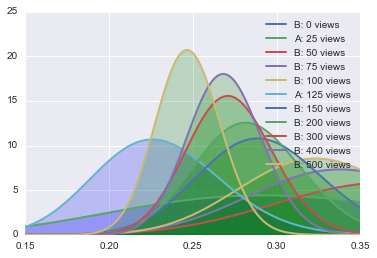

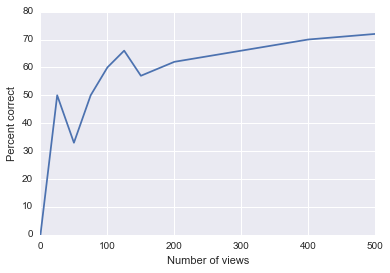

In [41]:
opt_bandit = []
n_views = [0, 25, 50, 75, 100, 125, 150, 200, 300, 400, 500]
for num in n_views :
    alphaA = A[:num].sum() + 1
    betaA = num - alphaA + 1
    ya = stats.beta.pdf(x, alphaA, betaA)
    
    alphaB = B[:num].sum() + 1
    betaB = num - alphaB + 1
    yb = stats.beta.pdf(x, alphaB, betaB)
   
    if alphaA == 0: alphaA += 1        
    if betaA == 0: betaA += 1 
    if alphaB == 0: alphaB += 1        
    if betaB == 0: betaB += 1 
    
    a = stats.beta.rvs(alphaA, betaA, size=1)
    b = stats.beta.rvs(alphaB, betaB, size=1)
    
    if  a>b :
        plot_with_fill(x, ya, label="A: {0} views".format(num), color='b')
        opt_bandit.append(0)
    else:
        plot_with_fill(x, yb, label="B: {0} views".format(num), color='g')
        opt_bandit.append(1)

plt.xlim(0.15, 0.35)
plt.legend()
plt.show()


opt_bandit_rate = []
for i,num in enumerate(n_views):
    opt_bandit_rate.append(sum(opt_bandit[:i])*100/len(opt_bandit[:i+1]))

plt.plot(n_views, opt_bandit_rate)
plt.xlabel('Number of views')
plt.ylabel('Percent correct')
plt.show()